In [116]:
import pandas as pd
import re
import pymorphy2
from pymystem3 import Mystem
from string import punctuation
from collections import Counter
from stop_words import get_stop_words
import matplotlib.pyplot as plt
from importlib import reload
import seaborn as sns
import analyzer
reload(analyzer)
from analyzer import Analyzer

%matplotlib inline

In [89]:
train = pd.read_csv('data/prep_train.csv')
val = pd.read_csv('data/prep_val.csv')

In [87]:
train = train[['text', 'class']].sample(10)

In [117]:
analyzer = Analyzer('train')
analyzer.analyzed_col = 'text'

In [78]:
train = analyzer.preprocess_pipeline(train)

Text lemmatized and trash removed...
Features is calculated...
Count POS is complete...


In [63]:
train[train['gram_err_text'] != 0]['text'].values[0]

'Профилактика наркомании в Украине \n В последнее время участились случаи заражения людей, употребляющих наркотические препараты. Так как многие граждане Украины и не подозревают об их существовании или употреблении наркотиков (а таких случаев много), то для многих из них это становится проблемой – ведь они часто сами попадают под действие запретов на наркотики: например при изготовлении марихуаны могут возникнуть побочные эффекты от приема препаратов; а употребление алкоголя может привести к серьезным проблемам со здоровьем... подробнее →>. >> Подробнее " > Читать далее... ]]</template">'

In [8]:
train = analyzer.add_ft_vectors(train)

Train fasttext model is complete...


129066it [13:54, 154.70it/s]


Ok tokens: 4891742 | Not ok tokens: 0


In [173]:
train = analyzer.add_d2v_vectors(train)

In [9]:
train['tokens_text'] = train['text'].apply(lambda x: analyzer.tokenize_text(x))
val['tokens_text'] = val['text'].apply(lambda x: analyzer.tokenize_text(x))

In [10]:
train['class'] = train['class'].map({'H': 0, 'M': 1})
val['class'] = val['class'].map({'H': 0, 'M': 1})

In [11]:
from kenlm import Model

kenlm_model = Model('../kenlm/lm_model_files/4.arpa')

Loading the LM will be faster if you build a binary file.
Reading /raid/nanosemantics/sasha/projects/kenlm/lm_model_files/4.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [12]:
def kenlm_score(text):
    return kenlm_model.score(text, bos = True, eos = True)

In [13]:
train['kenlm_score'] = train['tokens_text'].apply(lambda x: kenlm_score(x))
val['kenlm_score'] = val['tokens_text'].apply(lambda x: kenlm_score(x))

In [14]:
train[['kenlm_score', 'class']].corr()

,kenlm_score,class
kenlm_score,1.000000,-0.018013
class,-0.018013,1.000000


<AxesSubplot:>

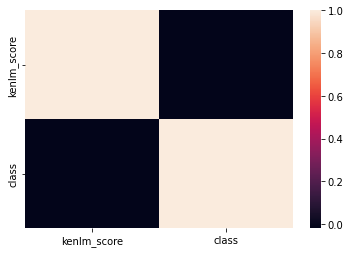

In [17]:
sns.heatmap(train[['kenlm_score', 'class']].corr())

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


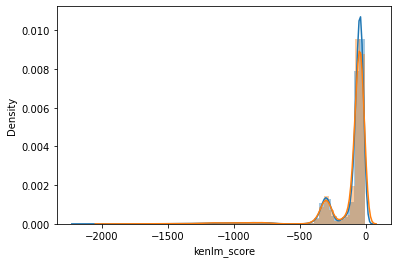

In [22]:
sns.distplot(train['kenlm_score'])
sns.distplot(val['kenlm_score'])
plt.show()

In [19]:
train['kenlm_score'].describe()

count    129066.000000
mean       -121.090890
std         198.034020
min       -2172.690186
25%         -88.316927
50%         -53.998533
75%         -34.850648
max          -3.746498
Name: kenlm_score, dtype: float64

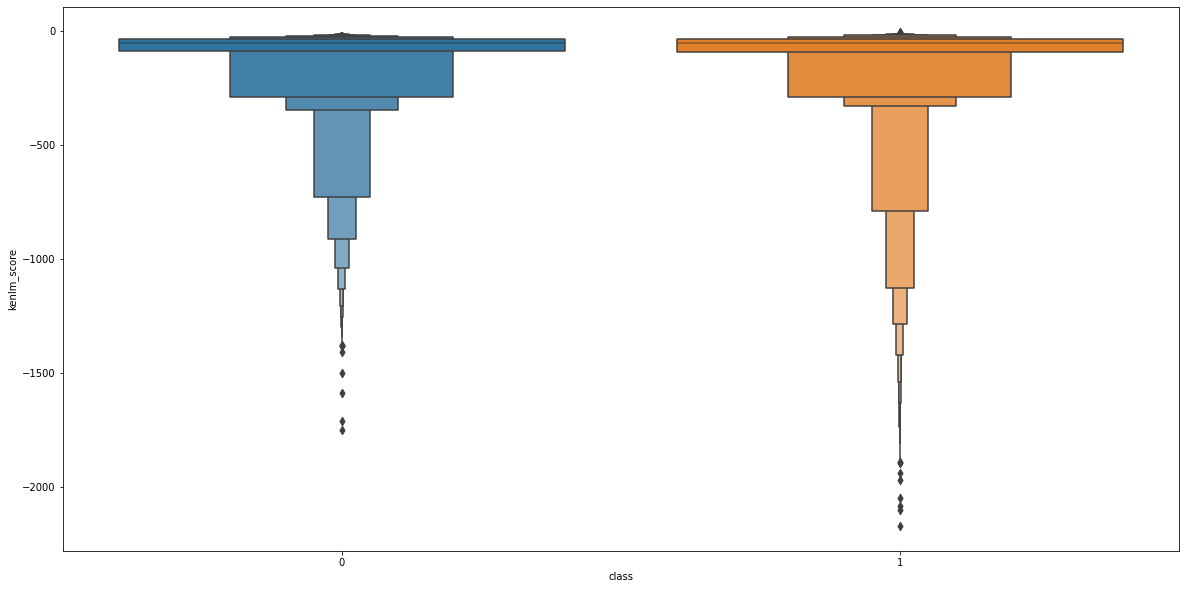

In [23]:
plt.figure(figsize=(20,10))
sns.boxenplot(data=train, x='class', y='kenlm_score')
plt.show()

In [37]:
train.groupby('class')['kenlm_score'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,64535.0,-117.523920,180.779635,-1750.181763,-87.057129,-53.768482,-34.647299,-3.746498
1,64531.0,-124.658081,213.843946,-2172.690186,-89.783241,-54.230854,-35.107962,-5.766485


In [17]:
inf_analyzer = Analyzer('inference')
inf_analyzer.analyzed_col = 'text'

In [18]:
#train = inf_analyzer.add_d2v_vectors(train[min_cols])
val = inf_analyzer.add_ft_vectors(val)

Train fasttext model is complete...


21511it [00:28, 752.05it/s]


Ok tokens: 815217 | Not ok tokens: 0


In [174]:
val = inf_analyzer.add_d2v_vectors(val)

In [55]:
# train.to_csv('prep_train.csv', index=False)
# val.to_csv('prep_val.csv', index=False)

In [24]:
train.isnull().sum().sort_values().tail(50)

id                                       0
tokens_text                              0
count_POS_text                           0
POS_text                                 0
count_lat_text                           0
count_kirr_text                          0
count_space_text                         0
mean_en_consonant_occurance_text         0
mean_en_vowel_occurance_text             0
mean_ru_consonant_occurance_text         0
mean_ru_vowel_occurance_text             0
sent_POS_text                            0
count_lowercase_text                     0
avg_word_len_text                        0
text                                     0
class                                    0
lemm_text                                0
kenlm_score                              0
count_punct_text                         0
count_numbers_text                       0
count_digits_text                        0
len_text_text                            0
count_uppercase_text                     0
POS_NOUN_te

In [27]:
train.fillna(0, inplace=True)

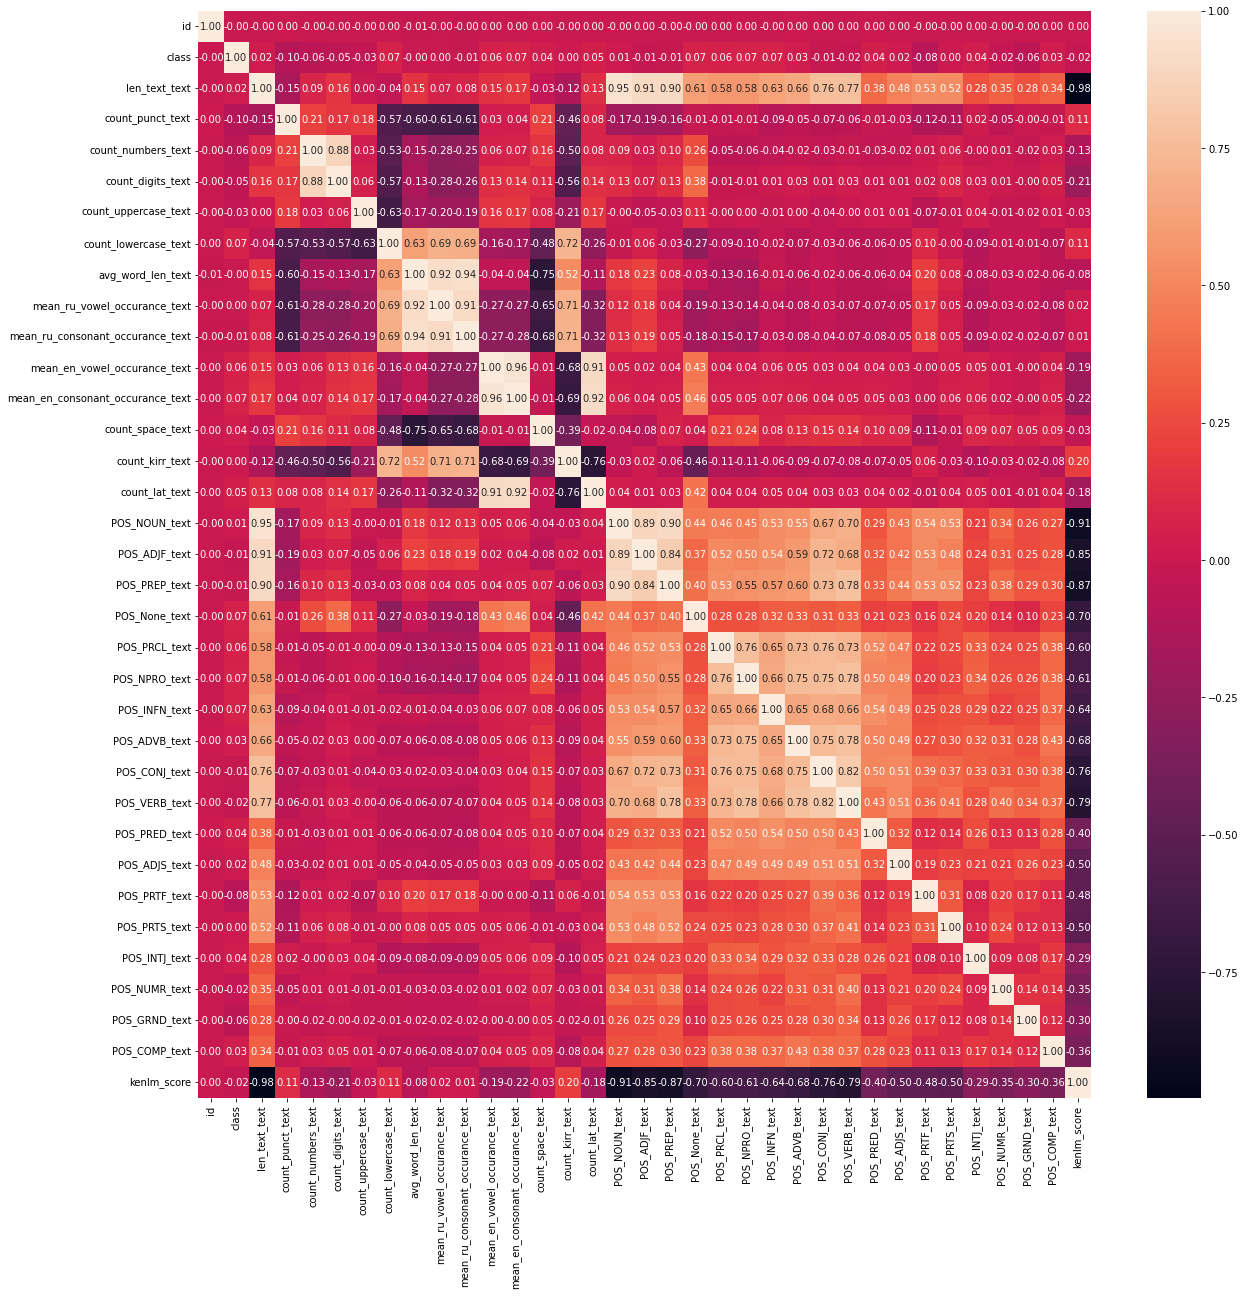

In [28]:
plt.figure(figsize=(20,20))

sns.heatmap(train[[col for col in list(train)]].corr(), annot=True, fmt='.2f')
plt.show()

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
import re
from sklearn.pipeline import Pipeline

In [30]:
label_cols = [col for col in list(train) if 'class' in col]

cols = list(set(train) - set(label_cols))
cols = [col for col in cols if 'ft_' not in col]
dropped_cols = ['count_POS_text', 'POS_text', 'id', 'text', 'tokens_text']

for col in dropped_cols:
    cols.pop(cols.index(col))

In [33]:
val.shape, val.dropna(subset=['lemm_text', 'sent_POS_text']).shape

((21511, 141), (21510, 141))

In [34]:
val.dropna(subset=['lemm_text', 'sent_POS_text'], inplace=True)

In [38]:
sorted(list(train[cols]))

['POS_ADJF_text',
 'POS_ADJS_text',
 'POS_ADVB_text',
 'POS_COMP_text',
 'POS_CONJ_text',
 'POS_GRND_text',
 'POS_INFN_text',
 'POS_INTJ_text',
 'POS_NOUN_text',
 'POS_NPRO_text',
 'POS_NUMR_text',
 'POS_None_text',
 'POS_PRCL_text',
 'POS_PRED_text',
 'POS_PREP_text',
 'POS_PRTF_text',
 'POS_PRTS_text',
 'POS_VERB_text',
 'avg_word_len_text',
 'count_digits_text',
 'count_kirr_text',
 'count_lat_text',
 'count_lowercase_text',
 'count_numbers_text',
 'count_punct_text',
 'count_space_text',
 'count_uppercase_text',
 'kenlm_score',
 'lemm_text',
 'len_text_text',
 'mean_en_consonant_occurance_text',
 'mean_en_vowel_occurance_text',
 'mean_ru_consonant_occurance_text',
 'mean_ru_vowel_occurance_text',
 'sent_POS_text']

In [39]:
val.isnull().sum().sort_values().tail(50)

len_text_text        0
lemm_text            0
class                0
text                 0
text_dv_2            0
text_dv_3            0
kenlm_score          0
text_dv_5            0
text_dv_11           0
text_dv_12           0
text_dv_13           0
text_dv_14           0
text_dv_15           0
text_dv_16           0
text_dv_17           0
text_dv_18           0
text_dv_10           0
text_dv_19           0
text_dv_21           0
text_dv_22           0
text_dv_23           0
text_dv_24           0
text_dv_25           0
text_dv_26           0
text_dv_27           0
text_dv_28           0
text_dv_20           0
text_dv_4            0
text_dv_9            0
text_dv_6            0
text_dv_7            0
text_dv_8            0
POS_NOUN_text      734
POS_VERB_text     3821
POS_PREP_text     3953
POS_ADJF_text     4792
POS_CONJ_text     8531
POS_NPRO_text    12215
POS_None_text    12235
POS_ADVB_text    13104
POS_PRCL_text    15019
POS_INFN_text    15589
POS_PRTF_text    17284
POS_PRTS_te

In [40]:
estimator=CatBoostClassifier(       text_features=['lemm_text', 'sent_POS_text'],
                                    loss_function='CrossEntropy',
                                    eval_metric='TotalF1',
                                    task_type='CPU',
                                    text_processing = {
                                        "tokenizers" : [{
                                            "tokenizer_id" : "Space",
                                            "separator_type" : "ByDelimiter",
                                            "delimiter" : " "
                                        }],

                                        "dictionaries" : [{
                                            "dictionary_id" : "BiGram",
                                            "token_level_type": "Word",
                                            "max_dictionary_size" : "150000",
                                            "occurrence_lower_bound" : "1",
                                            "gram_order" : "2"
                                        },
                                        {
                                            "dictionary_id" : "UniGram",
                                            "token_level_type": "Word",
                                            "max_dictionary_size" : "150000",
                                            "occurrence_lower_bound" : "2",
                                            "gram_order" : "1"
                                        },                                        
                                        {
                                            "dictionary_id" : "TriGram",
                                            "token_level_type": "Word",
                                            "max_dictionary_size" : "150000",
                                            "occurrence_lower_bound" : "2",
                                            "gram_order" : "3"
                                        }
                                        ],

                                        "feature_processing" : {
                                            "default" : [
                                                    {
                                                    "dictionaries_names" : ["UniGram", "BiGram"],
                                                    "feature_calcers" : ["BoW"],
                                                    "tokenizers_names" : ["Space"]
                                                },
                                                    {
                                                "dictionaries_names" : ["UniGram", "BiGram"],
                                                "feature_calcers" : ["NaiveBayes"],
                                                "tokenizers_names" : ["Space"]
                                            },{
                                                "dictionaries_names" : ["UniGram", "BiGram"],
                                                "feature_calcers" : ["BM25"],
                                                "tokenizers_names" : ["Space"]
                                            },
                                            ],
                                        }
                                    }
                                )

estimator.fit(train[cols], train['class'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6228922	total: 75.8ms	remaining: 1m 15s
1:	learn: 0.6384875	total: 119ms	remaining: 59.1s
2:	learn: 0.6407207	total: 168ms	remaining: 55.9s
3:	learn: 0.6370988	total: 205ms	remaining: 51s
4:	learn: 0.6423555	total: 242ms	remaining: 48.2s
5:	learn: 0.6428493	total: 279ms	remaining: 46.1s
6:	learn: 0.6436551	total: 333ms	remaining: 47.3s
7:	learn: 0.6448202	total: 385ms	remaining: 47.7s
8:	learn: 0.6452938	total: 422ms	remaining: 46.5s
9:	learn: 0.6460389	total: 467ms	remaining: 46.2s
10:	learn: 0.6470855	total: 510ms	remaining: 45.8s
11:	learn: 0.6474734	total: 546ms	remaining: 45s
12:	learn: 0.6476976	total: 579ms	remaining: 43.9s
13:	learn: 0.6482731	total: 614ms	remaining: 43.2s
14:	learn: 0.6476187	total: 656ms	remaining: 43.1s
15:	learn: 0.6477591	total: 696ms	remaining: 42.8s
16:	learn: 0.6475174	total: 733ms	remaining: 42.4s
17:	learn: 0.6477796	total: 767ms	remaining: 41.8s
18:	learn: 0.6477807	total: 807ms	remaining: 41.7s
19:	learn: 0.6486872	total: 841ms	remaining

162:	learn: 0.6818601	total: 5.8s	remaining: 29.8s
163:	learn: 0.6820695	total: 5.84s	remaining: 29.7s
164:	learn: 0.6821004	total: 5.87s	remaining: 29.7s
165:	learn: 0.6822170	total: 5.9s	remaining: 29.6s
166:	learn: 0.6821405	total: 5.93s	remaining: 29.6s
167:	learn: 0.6823347	total: 5.96s	remaining: 29.5s
168:	learn: 0.6823273	total: 6s	remaining: 29.5s
169:	learn: 0.6824363	total: 6.03s	remaining: 29.4s
170:	learn: 0.6826380	total: 6.06s	remaining: 29.4s
171:	learn: 0.6825761	total: 6.09s	remaining: 29.3s
172:	learn: 0.6827157	total: 6.13s	remaining: 29.3s
173:	learn: 0.6829483	total: 6.16s	remaining: 29.2s
174:	learn: 0.6829642	total: 6.2s	remaining: 29.2s
175:	learn: 0.6830102	total: 6.24s	remaining: 29.2s
176:	learn: 0.6830874	total: 6.29s	remaining: 29.2s
177:	learn: 0.6833969	total: 6.32s	remaining: 29.2s
178:	learn: 0.6836677	total: 6.35s	remaining: 29.1s
179:	learn: 0.6836603	total: 6.4s	remaining: 29.2s
180:	learn: 0.6837844	total: 6.44s	remaining: 29.1s
181:	learn: 0.68416

325:	learn: 0.6935234	total: 11.4s	remaining: 23.7s
326:	learn: 0.6935466	total: 11.5s	remaining: 23.6s
327:	learn: 0.6936008	total: 11.5s	remaining: 23.6s
328:	learn: 0.6936396	total: 11.5s	remaining: 23.5s
329:	learn: 0.6937015	total: 11.6s	remaining: 23.5s
330:	learn: 0.6937012	total: 11.6s	remaining: 23.5s
331:	learn: 0.6937169	total: 11.6s	remaining: 23.4s
332:	learn: 0.6938639	total: 11.7s	remaining: 23.4s
333:	learn: 0.6939104	total: 11.7s	remaining: 23.3s
334:	learn: 0.6939417	total: 11.7s	remaining: 23.3s
335:	learn: 0.6941042	total: 11.8s	remaining: 23.2s
336:	learn: 0.6940889	total: 11.8s	remaining: 23.2s
337:	learn: 0.6941120	total: 11.8s	remaining: 23.2s
338:	learn: 0.6941662	total: 11.9s	remaining: 23.2s
339:	learn: 0.6940426	total: 11.9s	remaining: 23.2s
340:	learn: 0.6940195	total: 12s	remaining: 23.1s
341:	learn: 0.6941979	total: 12s	remaining: 23.1s
342:	learn: 0.6941205	total: 12s	remaining: 23s
343:	learn: 0.6942443	total: 12.1s	remaining: 23s
344:	learn: 0.6942985	

486:	learn: 0.7028765	total: 17.1s	remaining: 18.1s
487:	learn: 0.7028766	total: 17.2s	remaining: 18s
488:	learn: 0.7029773	total: 17.2s	remaining: 18s
489:	learn: 0.7030552	total: 17.3s	remaining: 18s
490:	learn: 0.7030859	total: 17.3s	remaining: 17.9s
491:	learn: 0.7031555	total: 17.3s	remaining: 17.9s
492:	learn: 0.7031014	total: 17.4s	remaining: 17.9s
493:	learn: 0.7031404	total: 17.4s	remaining: 17.8s
494:	learn: 0.7031712	total: 17.4s	remaining: 17.8s
495:	learn: 0.7032873	total: 17.5s	remaining: 17.7s
496:	learn: 0.7034962	total: 17.5s	remaining: 17.7s
497:	learn: 0.7035426	total: 17.5s	remaining: 17.7s
498:	learn: 0.7035812	total: 17.6s	remaining: 17.6s
499:	learn: 0.7035735	total: 17.6s	remaining: 17.6s
500:	learn: 0.7035965	total: 17.6s	remaining: 17.5s
501:	learn: 0.7036746	total: 17.6s	remaining: 17.5s
502:	learn: 0.7035736	total: 17.7s	remaining: 17.5s
503:	learn: 0.7035970	total: 17.7s	remaining: 17.4s
504:	learn: 0.7036743	total: 17.8s	remaining: 17.4s
505:	learn: 0.7037

646:	learn: 0.7106099	total: 22.6s	remaining: 12.3s
647:	learn: 0.7107337	total: 22.6s	remaining: 12.3s
648:	learn: 0.7108193	total: 22.6s	remaining: 12.2s
649:	learn: 0.7108660	total: 22.7s	remaining: 12.2s
650:	learn: 0.7108581	total: 22.7s	remaining: 12.2s
651:	learn: 0.7109511	total: 22.7s	remaining: 12.1s
652:	learn: 0.7110439	total: 22.8s	remaining: 12.1s
653:	learn: 0.7111293	total: 22.8s	remaining: 12.1s
654:	learn: 0.7111834	total: 22.8s	remaining: 12s
655:	learn: 0.7112300	total: 22.9s	remaining: 12s
656:	learn: 0.7111913	total: 22.9s	remaining: 11.9s
657:	learn: 0.7112224	total: 22.9s	remaining: 11.9s
658:	learn: 0.7112302	total: 22.9s	remaining: 11.9s
659:	learn: 0.7113386	total: 23s	remaining: 11.8s
660:	learn: 0.7113698	total: 23s	remaining: 11.8s
661:	learn: 0.7113622	total: 23.1s	remaining: 11.8s
662:	learn: 0.7114086	total: 23.1s	remaining: 11.8s
663:	learn: 0.7114320	total: 23.2s	remaining: 11.7s
664:	learn: 0.7115173	total: 23.2s	remaining: 11.7s
665:	learn: 0.711563

808:	learn: 0.7171044	total: 28.1s	remaining: 6.63s
809:	learn: 0.7171819	total: 28.1s	remaining: 6.6s
810:	learn: 0.7172440	total: 28.2s	remaining: 6.57s
811:	learn: 0.7172519	total: 28.2s	remaining: 6.53s
812:	learn: 0.7172441	total: 28.3s	remaining: 6.5s
813:	learn: 0.7172287	total: 28.3s	remaining: 6.46s
814:	learn: 0.7172829	total: 28.3s	remaining: 6.43s
815:	learn: 0.7172830	total: 28.4s	remaining: 6.39s
816:	learn: 0.7172675	total: 28.4s	remaining: 6.36s
817:	learn: 0.7171901	total: 28.4s	remaining: 6.32s
818:	learn: 0.7173063	total: 28.4s	remaining: 6.29s
819:	learn: 0.7173449	total: 28.5s	remaining: 6.25s
820:	learn: 0.7174147	total: 28.5s	remaining: 6.22s
821:	learn: 0.7175154	total: 28.6s	remaining: 6.18s
822:	learn: 0.7174690	total: 28.6s	remaining: 6.15s
823:	learn: 0.7174534	total: 28.6s	remaining: 6.11s
824:	learn: 0.7175001	total: 28.6s	remaining: 6.08s
825:	learn: 0.7175543	total: 28.7s	remaining: 6.04s
826:	learn: 0.7176163	total: 28.7s	remaining: 6s
827:	learn: 0.717

967:	learn: 0.7225678	total: 33.4s	remaining: 1.1s
968:	learn: 0.7225678	total: 33.5s	remaining: 1.07s
969:	learn: 0.7226219	total: 33.5s	remaining: 1.04s
970:	learn: 0.7225600	total: 33.5s	remaining: 1s
971:	learn: 0.7226376	total: 33.6s	remaining: 967ms
972:	learn: 0.7226530	total: 33.6s	remaining: 932ms
973:	learn: 0.7227150	total: 33.6s	remaining: 898ms
974:	learn: 0.7227151	total: 33.7s	remaining: 863ms
975:	learn: 0.7227461	total: 33.7s	remaining: 829ms
976:	learn: 0.7229010	total: 33.7s	remaining: 794ms
977:	learn: 0.7229166	total: 33.8s	remaining: 760ms
978:	learn: 0.7229243	total: 33.8s	remaining: 725ms
979:	learn: 0.7229165	total: 33.8s	remaining: 691ms
980:	learn: 0.7230018	total: 33.9s	remaining: 656ms
981:	learn: 0.7230327	total: 33.9s	remaining: 622ms
982:	learn: 0.7231024	total: 33.9s	remaining: 587ms
983:	learn: 0.7231179	total: 34s	remaining: 553ms
984:	learn: 0.7231643	total: 34s	remaining: 518ms
985:	learn: 0.7232573	total: 34.1s	remaining: 484ms
986:	learn: 0.723241

In [ ]:
df_pool = Pool(data = train[cols], label = train['class'], text_features=['lemm_text', 'sent_POS_text'])

params = {'iterations': 20000,
'one_hot_max_size': 31,
'learning_rate': 0.005,
'loss_function': 'Logloss',
'custom_metric': ['TotalF1', 'AUC', 'Precision', 'Recall', 'Logloss'],
'eval_metric': 'TotalF1',
'text_processing': """{
                                        "tokenizers" : [{
                                            "tokenizer_id" : "Space",
                                            "separator_type" : "ByDelimiter",
                                            "delimiter" : " "
                                        }],

                                        "dictionaries" : [{
                                            "dictionary_id" : "BiGram",
                                            "token_level_type": "Word",
                                            "max_dictionary_size" : "150000",
                                            "occurrence_lower_bound" : "1",
                                            "gram_order" : "2"
                                        },
                                        {
                                            "dictionary_id" : "UniGram",
                                            "token_level_type": "Word",
                                            "max_dictionary_size" : "150000",
                                            "occurrence_lower_bound" : "2",
                                            "gram_order" : "1"
                                        },                                        
                                        {
                                            "dictionary_id" : "TriGram",
                                            "token_level_type": "Word",
                                            "max_dictionary_size" : "150000",
                                            "occurrence_lower_bound" : "2",
                                            "gram_order" : "3"
                                        }
                                        ],

                                        "feature_processing" : {
                                            "default" : [
                                                    {
                                                    "dictionaries_names" : ["UniGram", "BiGram"],
                                                    "feature_calcers" : ["BoW"],
                                                    "tokenizers_names" : ["Space"]
                                                },
                                                    {
                                                "dictionaries_names" : ["UniGram", "BiGram"],
                                                "feature_calcers" : ["NaiveBayes"],
                                                "tokenizers_names" : ["Space"]
                                            },{
                                                "dictionaries_names" : ["UniGram", "BiGram"],
                                                "feature_calcers" : ["BM25"],
                                                "tokenizers_names" : ["Space"]
                                            },
                                            ],
                                        }
                                    }"""
}

clf = cv(df_pool, params, fold_count = 5, early_stopping_rounds = 200, plot = True)

In [43]:
val.fillna(0, inplace=True)

In [44]:
y_pred = estimator.predict(val[cols])

In [45]:
print(classification_report(val['class'], y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     10755
           1       0.71      0.72      0.71     10755

    accuracy                           0.71     21510
   macro avg       0.71      0.71      0.71     21510
weighted avg       0.71      0.71      0.71     21510



In [47]:
feature_importances = pd.DataFrame(zip(list(train[cols]), sorted(list(estimator.get_feature_importance()))), columns=['feat', 'coef']).sort_values(by='coef', ascending=False).head(50)

In [57]:
feature_importances['coef'] = feature_importances['coef'].astype('float')

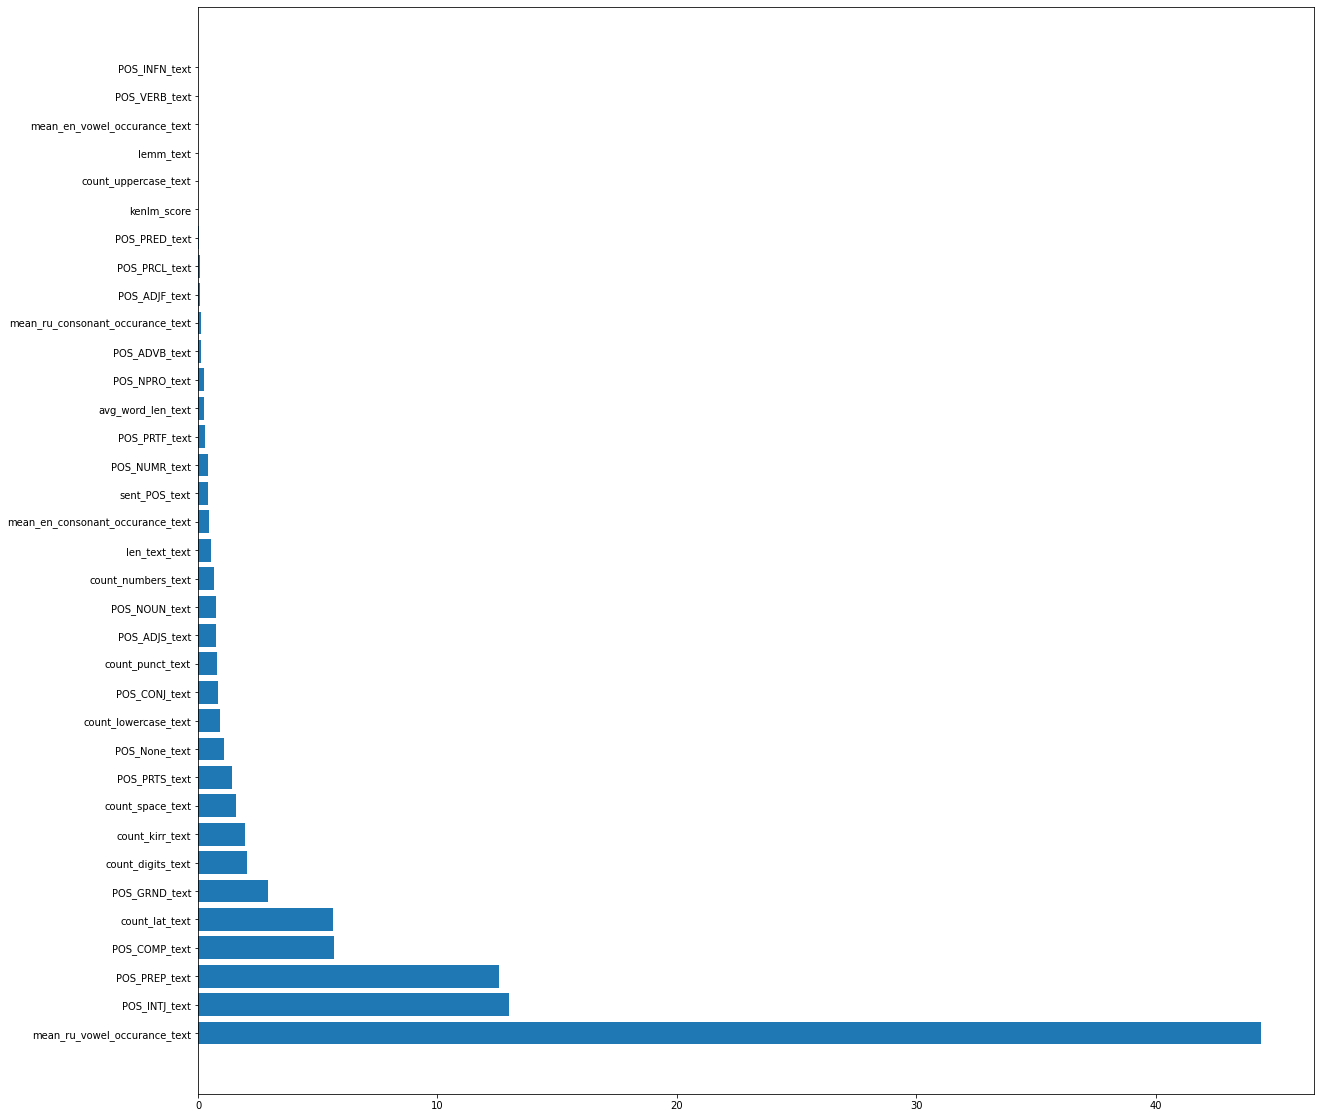

In [77]:
plt.figure(figsize=(20,20))
plt.barh(feature_importances['feat'], feature_importances['coef'])
plt.show()